In [27]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats

%matplotlib inline 

In [2]:
# Общая настройка графиков
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(4,4)}
        )

In [3]:
data = pd.read_csv('gamedev_data.csv')

In [4]:
data.head()

,AbGroup,user_id,time_stamp,install_date,event_name,platform,network_name,country_name,InGameTime,LastCompletedLevel,avg_energy_amount,revenue_on_event,revenue_on_other_activities,gold_on_event,gold_on_other_activities
0,Control,d60ebcaecff2dc1d360a8a41271e6fd8a902c107,2020-02-10,2019-11-10,ResourceSpend,itunes,Organic,United Kingdom of Great Britain and Northern I...,276180,345,54.0,0.0,0.0,NaN,NaN
1,Test,f6e385b0ab43d5aea9cfcc408aa84029a4ea5fdb,2020-03-04,2019-11-05,ResourceSpend,itunes,Paid,United States of America,166095,199,50.0,0.0,0.0,NaN,NaN
2,Control,a4c80c8524e2c11cc238553d7b02da01ce2aad66,2020-02-26,2020-01-02,ResourceSpend,itunes,Paid,Canada,240986,84,39.0,0.0,0.0,NaN,NaN
3,Control,7ea2e4599ae33760c307e254839317bd5b17a63c,2020-02-21,2020-01-13,ResourceSpend,itunes,Organic,France,989822,1176,21.0,0.0,0.0,NaN,NaN
4,Control,6495168982929360dc6d84bf0766d8963a7ddc41,2020-02-18,2020-02-05,ResourceSpend,itunes,Paid,Spain,52106,66,43.0,0.0,0.0,500.0,NaN


In [5]:
data.shape

(696840, 15)

In [6]:
data.dtypes

AbGroup                         object
user_id                         object
time_stamp                      object
install_date                    object
event_name                      object
platform                        object
network_name                    object
country_name                    object
InGameTime                       int64
LastCompletedLevel               int64
avg_energy_amount              float64
revenue_on_event               float64
revenue_on_other_activities    float64
gold_on_event                  float64
gold_on_other_activities       float64
dtype: object

In [7]:
data.time_stamp = pd.to_datetime(data.time_stamp)
data.install_date = pd.to_datetime(data.install_date)

In [8]:
data.isnull().sum()

AbGroup                             0
user_id                             0
time_stamp                          0
install_date                        0
event_name                          0
platform                            0
network_name                        0
country_name                        0
InGameTime                          0
LastCompletedLevel                  0
avg_energy_amount                   0
revenue_on_event                    0
revenue_on_other_activities         0
gold_on_event                  651428
gold_on_other_activities       528647
dtype: int64

In [9]:
data.query("event_name == 'ResourceSpend' and gold_on_event.isnull() and gold_on_other_activities.isnull()").shape

(487387, 15)

Делаю предположение о том, что в игре есть друга валюта помимо золота, поэтому и так много null значений.

# Изучение данных

Для начала оценю разбиение по группам в эксперименте

<AxesSubplot:xlabel='AbGroup', ylabel='groups_num'>

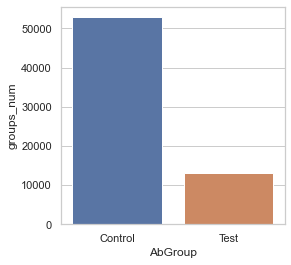

In [22]:
test = data.query("AbGroup == 'Test'")
control = data.query("AbGroup == 'Control'")

groups = data.groupby('AbGroup', as_index = False ) \
             .agg(groups_num = ('user_id', 'nunique'))


sns.barplot(x = groups.AbGroup, y = groups.groups_num)

Можно заметить, что в контрольной группе кратно больше пользователей, чем в тестовой.

Теперь оценю время проведения эксперимента


In [11]:
print(f"Минимальная дата в тестовой группе: {min(test.time_stamp)}")
print(f"Максимальная дата в тестовой группе: {max(test.time_stamp)}")
print(f"Минимальная дата в контрольной группе: {min(control.time_stamp)}")
print(f"Максимальная дата в контрольной группе: {max(control.time_stamp)}")

Минимальная дата в тестовой группе: 2020-02-06 00:00:00
Максимальная дата в тестовой группе: 2020-03-04 00:00:00
Минимальная дата в контрольной группе: 2020-02-06 00:00:00
Максимальная дата в контрольной группе: 2020-03-04 00:00:00


Эксперимент проводился в один и тот же временной промежуток, что хорошо.

Далее хотелось бы рассмотреть как были распределены пользователи по странам.


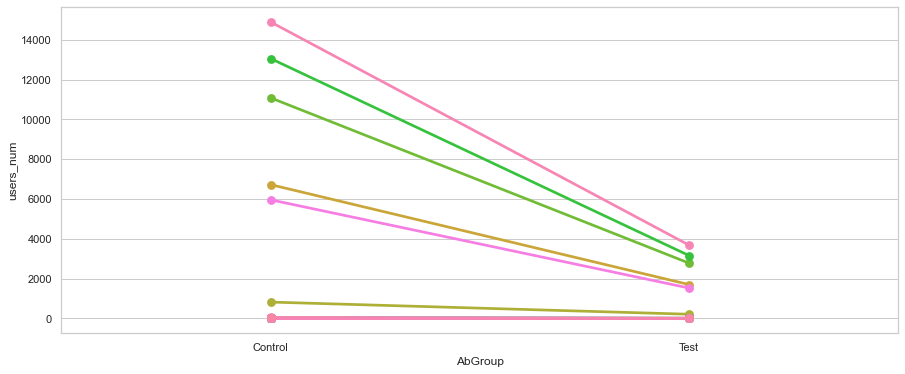

In [23]:
f, ax = plt.subplots(figsize=(15, 6))
countries = data.groupby(['country_name', 'AbGroup'], as_index = False) \
               .agg(users_num = ('user_id', 'nunique'))
sns.pointplot(x = countries.AbGroup, y = countries.users_num, hue = countries.country_name)
plt.legend([],[], frameon=False)

Изучая распределение пользователей по странам видно, что в контрольной группе во всех странах пользователей больше. Это логично, т.к в контрольной группе пользователей больше в целом.

Посмотрим на распределение пользователей по платформам

In [24]:
control.groupby('platform', as_index = False) \
    .agg(users_num = ('user_id', 'nunique'))


,platform,users_num
0,itunes,52854


In [25]:
test.groupby('platform', as_index = False) \
    .agg(users_num = ('user_id', 'nunique'))


,platform,users_num
0,itunes,13149


Можно заметить, что в группах всего одна платформа - ios.

Теперь сравню несколько количественных значений по группам.


In [26]:
data['InGameHours'] = data.InGameTime / 3600
InGameTime = data.groupby('AbGroup', as_index = False) \
                 .agg(avg_time = ('InGameHours', 'mean'))

InGameTime


,AbGroup,avg_time
0,Control,895.442697
1,Test,896.526997


В целом, по проведенному времени пользователей разделили +- одинаково даже несмотря на то, что в контрольной группе показатель выше на 37% 

In [16]:
data.groupby('AbGroup', as_index = False) \
    .agg({
         'gold_on_event':'mean',
         'gold_on_other_activities':'mean',
         'revenue_on_event':'mean',
         'revenue_on_other_activities':'mean'
         })


,AbGroup,gold_on_event,gold_on_other_activities,revenue_on_event,revenue_on_other_activities
0,Control,1965.211658,911.892213,0.0,0.0
1,Test,2104.606505,1035.412000,0.0,0.0


In [17]:
data.query("revenue_on_event > 0")

,AbGroup,user_id,time_stamp,install_date,event_name,platform,network_name,country_name,InGameTime,LastCompletedLevel,avg_energy_amount,revenue_on_event,revenue_on_other_activities,gold_on_event,gold_on_other_activities,InGameHours


In [18]:
data.event_name.unique()

array(['ResourceSpend'], dtype=object)

Значения для золота в тестовой и контрольной группе примерно одинаковые, однако в тестовой группе в конкретном эксперименте обе метркии показали рост. Выяснился и другой интересный момент - в датасете отсутствуют операции за настоящие деньги, поэтому закрадываются сомнения и в количестве null значений для покупок за внутреннюю валюту. Могу предположить, что в ходе эксперимента произошла какая-то ошибка, так как:
1. Много событий покупки за внутреннюю валюту с null значениями в колонках с золотом;
2. отсутствует Google play в платформе (в тз указан);
3. отсутствуют покупки за реальные деньги (в тз указаны). 

Исходя из этого буду сравнивать группы по датасету, в котором отсутствуют null значения. 

Так как отсутствуют колонки с покупками за реальную валюту, то критерием успешности эксперимента буду считать стат. значимое увеличение потраченного золота на ивентовые предметы. Золото потраченное на не ивентовые продукты учитывать не буду, т.к исходя из тз, дизайнеры изменили только иконку покупки продуктов товаров,связанных с событием. 

Если бы данные были бы полными, то ожидпалось бы также увеличение трат реальных денег на ивентовые продукты и рост среднего чека на покупку не ивентовых товаров, что включает в себя золотою (revenue_on_other_activities)

In [39]:
data = data.query("gold_on_event.notnull()")

В датафрейме 45412 строк. Этого вполне достаточно для сравнения, даже если в записи не было никакой ошибки

# Сравнение двух групп

In [42]:
test = data.query("AbGroup == 'Test'").gold_on_event
control = data.query("AbGroup == 'Control'").gold_on_event

Text(0.5, 0, 'Потраченное золото')

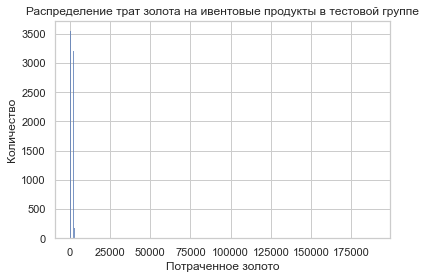

In [43]:
sns.histplot(test)
plt.title('Распределение трат золота на ивентовые продукты в тестовой группе')
plt.ylabel('Количество')
plt.xlabel('Потраченное золото')

Text(0.5, 0, 'Потраченное золото')

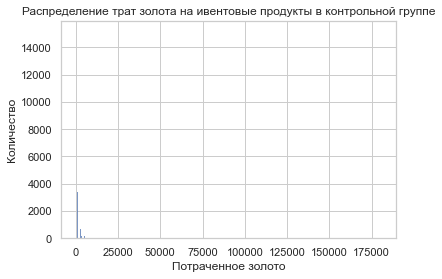

In [44]:
sns.histplot(control)
plt.title('Распределение трат золота на ивентовые продукты в контрольной группе')
plt.ylabel('Количество')
plt.xlabel('Потраченное золото')

Распределения с длиным хвостом являются довольно типичными для распределений, связанных с деньгами. Большинство людей тратят около 2000 голды, но есть и юзеры, которые тратят кратно больше. 

Для выбора статистического теста для начала проверю гомогенность дисперсий в двух группах. 

In [52]:
p_value = stats.levene(test, control)[1]
print(f"""
H0 – в генеральной совокупности никакого различия между дисперсиями контрольных групп нет. 
H1 – дисперсии контрольных групп не равны в генеральной совокупности. 
P-value: {p_value}.
""")


H0 – в генеральной совокупности никакого различия между дисперсиями контрольных групп нет. 
H1 – дисперсии контрольных групп не равны в генеральной совокупности. 
P-value: 0.017074567802208836.



У нас есть основания отвергнуть нулевую гипотезу о том, что в генеральной совокупности никакого различия между дисперсиями контрольных групп нет, т.к p-value < 0.05.

Следовательно, в такой ситуации лучше воздержаться от применения т-теста. Для сравненния двух групп между собой воспользуюсь бутстрапом.

In [55]:
avg_diff = []

for i in range(10000):
    sample_data_control = control.sample(frac=1, replace=True)
    sample_median_control = sample_data_control.mean()
    
    
    sample_data_exp = test.sample(frac=1, replace=True)
    sample_median_exp = sample_data_exp.mean()
    
    sample_median_diff = sample_median_control - sample_median_exp
    avg_diff.append(sample_median_diff)

Оценивать результат буду по доверительному интервалу.

In [56]:
print(f"Доверительный интервал: {pd.Series(avg_diff).quantile(0.025)} - {pd.Series(avg_diff).quantile(0.975)}")


Доверительный интервал: -256.38705475559567 - -35.97597627430313


Разница между средними значениями отрицательны и стат. значимы, поскольку доверительный интервал не включают в себя 0. Исходя из этого делаю вывод, что конкретно в этом эксперименте изменение иконки ивентовых продуктов привело к стат. значимому увеличению потраченного золота на покупку ивентовых продуктов. 

Исходя из отмеченных в начале ожидаемых результатов считаю эксперимент удачным, обновление можно выкатывать на всех пользователей.
